In [1]:
import re
from lxml import etree
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
import seaborn as sns

### WoW NPC analysis

* Josh mentioned there is probably an inflection point c.a lvl 80 where raid difficulty is introduced (possibly find confidence intervals before/after this?)
* Iskierka mentioned that **DPS, spawn rate** are also valuable dimensions to look at (specifically mentioned $\sqrt(DPS*HP) * \textrm{(relative spawn rate)}$)
  * this got me thinking: $\tau = \frac{HP}{DPS}$ is a characteristic time for the enemy to kill itself, might be helpful for characterizing the threat level
* > 17:13 < Astraltor-> do npcs have things that make them more or less durable? **(like armor, hp regeneration, whatever)** tho i guess it probably wouldn't matter much. neat grpah tho!
* >17:16 < SnoopJeDi> I'm also generally curious what all the high-level entries are that have HPs in the [1, 1000] range  
  >17:16 < Astraltor-> **swarm enemies?**  
  >17:16 < SnoopJeDi> hmm maybe!  
  ~~>17:16 < SnoopJeDi> I should also make it a **hexplot**~~
* There should probably be some kind of `NPCInfo` class that stores information and contains the logic for extracting stuff from a page...

In [2]:
maxprint = 100 
maxprocess = 1e7
numprocessed = 0
names = []
levels = []
healths = []
itertree = etree.iterparse('wowwiki_pages_current.xml')
for event, element in itertree:
    if numprocessed > maxprocess:
        raise Exception('Maximum number of records processed')
        break
    numprocessed += 1
    if element.tag.endswith('text') and element.text and 'health' in element.text:
        name_re = re.search('name ?= ?(.+)(\||\n)', element.text)
        health_re = re.search('health ?= ?([\d,]+)', element.text)
        level_re = re.search('level ?= ?(.+)(\n|\|)', element.text)
        
        health = int(health_re.group(1).replace(',', '')) if health_re else None
        try:
            level = int(level_re.group(1)) 
        except:
            level = np.nan
        name = name_re.group(1) if name_re else None
        if name and health:
            names.append(name)
            levels.append(level)
            healths.append(health)
    element.clear()

/home/vagrant/miniconda3/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in less_equal


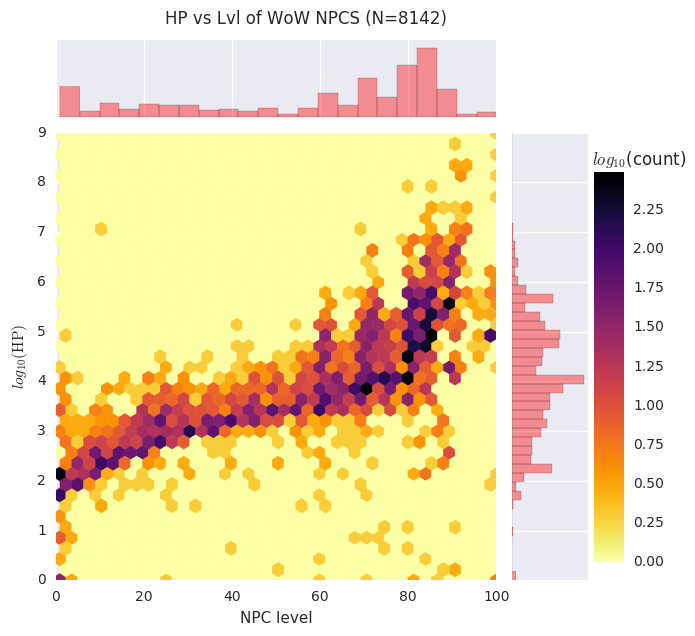

In [26]:
LEVEL_CUTOFF = 100
hps = np.log10(healths)
lvls = np.array(levels)
idx = (lvls <= LEVEL_CUTOFF) & np.isfinite(lvls)
ax = sns.jointplot(lvls[idx], hps[idx], stat_func=None, kind='hex', 
                    xlim=(0, LEVEL_CUTOFF), bins='log', color='r', cmap='inferno_r')
ax.fig.suptitle('HP vs Lvl of WoW NPCS (N={N})'.format(N=idx.sum()), y=1.02)
ax.ax_joint.set_xlabel('NPC level')
ax.ax_joint.set_ylabel(r'$log_{10}(\mathrm{HP})$')
cax = ax.fig.add_axes([0.98, 0.1, 0.05, 0.65])
plt.colorbar(cax=cax)
cax.set_title('$log_{10}$(count)', x=1.5)